In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import layers
import tensorflow_probability as tfp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
tfd = tfp.distributions

# Učitavanje skupa podataka
podaci = pd.read_csv('winequality-red.csv')

In [2]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Probability version:", tfp.__version__)

TensorFlow version: 2.10.0
TensorFlow Probability version: 0.18.0


In [3]:
data = podaci
X = data.drop(columns=['quality']).values
y = data['quality'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

In [20]:
# Custom callback to track training, validation loss (ELBO), MSE, and time per epoch
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_loss = []  # Track ELBO loss for training
        self.val_loss = []  # Track ELBO loss for validation
        self.train_mse_loss = []  # Track MSE for training
        self.val_mse_loss = []  # Track MSE for validation
        self.epoch_times = []  # To track time per epoch
        self.start_time = time.time()  # Track the overall training start time

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()  # Start time for each epoch

    def on_epoch_end(self, epoch, logs=None):
        # Store ELBO loss
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)

        # Store MSE
        train_mse = logs.get('mse')
        val_mse = logs.get('val_mse')
        self.train_mse_loss.append(train_mse)
        self.val_mse_loss.append(val_mse)

        # Track epoch time
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

        # Print losses, MSE, and epoch time
        if epoch%25==0:
          print(f"Epoch {epoch + 1}: Time = {epoch_time:.2f}s, "
                f"Train ELBO Loss = {train_loss:.4f}, Validation ELBO Loss = {val_loss:.4f}, ")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        print(f"Training completed in {total_time:.2f} seconds")

Epoch 1: Time = 2.05s, Train ELBO Loss = 48.4588, Validation ELBO Loss = 46.2949, 
Epoch 26: Time = 0.09s, Train ELBO Loss = 25.5214, Validation ELBO Loss = 25.2805, 
Epoch 51: Time = 0.09s, Train ELBO Loss = 13.9025, Validation ELBO Loss = 13.7518, 
Epoch 76: Time = 0.09s, Train ELBO Loss = 4.3710, Validation ELBO Loss = 4.2373, 
Epoch 101: Time = 0.09s, Train ELBO Loss = 1.0239, Validation ELBO Loss = 0.9562, 
Epoch 126: Time = 0.09s, Train ELBO Loss = 0.7025, Validation ELBO Loss = 0.6811, 
Epoch 151: Time = 0.09s, Train ELBO Loss = 0.6649, Validation ELBO Loss = 0.7370, 
Epoch 176: Time = 0.09s, Train ELBO Loss = 0.6399, Validation ELBO Loss = 0.5974, 
Epoch 201: Time = 0.09s, Train ELBO Loss = 0.5959, Validation ELBO Loss = 0.5465, 
Epoch 226: Time = 0.09s, Train ELBO Loss = 0.5693, Validation ELBO Loss = 0.5406, 
Epoch 251: Time = 0.09s, Train ELBO Loss = 0.5722, Validation ELBO Loss = 0.5607, 
Epoch 276: Time = 0.09s, Train ELBO Loss = 0.5526, Validation ELBO Loss = 0.5068, 
Epo

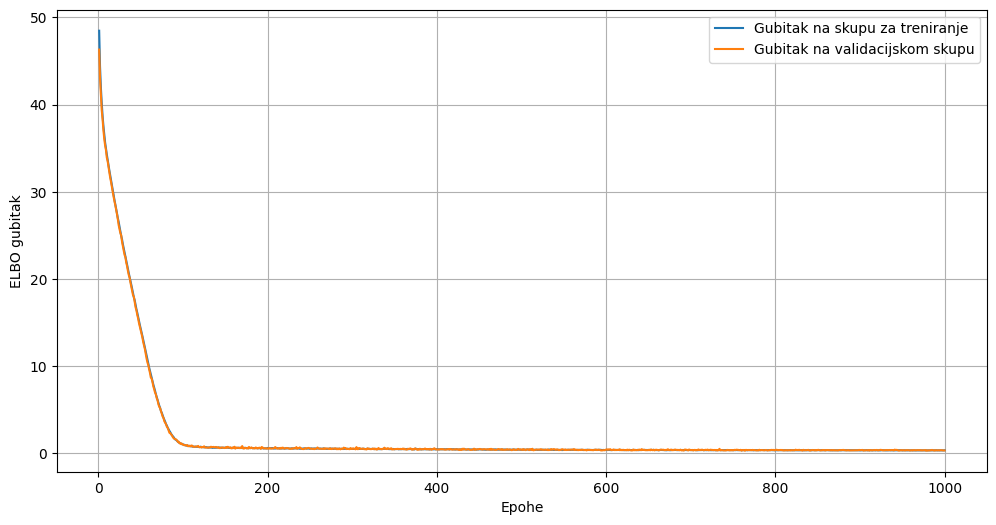

In [30]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    history = LossHistory()

    # Track the start time
    start_time = time.time()

    # Train the model with the callback
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[history]
    )

    # Track the end time
    end_time = time.time()

    # Return the trained model, the history object, and the total training time
    return model, history, end_time - start_time


# Define the prior weight distribution as Normal with mean=0 and stddev=1.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size  # Total number of parameters (weights + biases)
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n),
                    scale_diag=tf.constant(0.0316, shape=(n,), dtype=tf.float32)
                )
            )
        ]
    )
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size  # Total number of parameters (weights + biases)
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                shape=(2 * n,),
                dtype=dtype,
                initializer=tf.keras.initializers.Constant([0] * n + [-7.0] * n)
            ),
            tfp.layers.DistributionLambda(
                make_distribution_fn=lambda t: tfp.distributions.Independent(
                    tfp.distributions.Normal(
                        loc=t[..., :n],
                        scale=tf.math.softplus(t[..., n:])
                    ),
                    reinterpreted_batch_ndims=1
                )
            ),
        ]
    )
    return posterior_model


def create_bnn_model(input_dim, train_size, lr):
    kl_weight = 1 / train_size  # Scale KL divergence by training size
    inputs = keras.Input(shape=(input_dim,))  # Input layer

    # Add hidden layers with uncertainty using DenseVariational
    features = inputs
    for units in [32, 32]:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=kl_weight,
            activation="relu",
        )(features)

    # Final output layer predicts mean and log-variance
    outputs = layers.Dense(units=2)(features)  # Predicts mean and log-variance

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    def nll_gaussian(y, y_pred):
        mean = y_pred[:, 0]
        log_variance = y_pred[:, 1]
        log_variance = tf.clip_by_value(log_variance, -10, 20)
        variance = tf.exp(log_variance)
        variance = tf.clip_by_value(variance, 1e-8, 1e3)
        penalty = 0.01 * tf.reduce_mean(log_variance ** 2)
        return 0.5 * tf.reduce_mean((y - mean) ** 2 / variance + log_variance)

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9
    )
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)


    model.compile(
        optimizer=optimizer,
        loss=nll_gaussian,
        metrics=['mse']
    )
    return model


no_epochs = 1000
learning_rate = 0.001

bnn = create_bnn_model(X_train.shape[1], X_train.shape[0], lr=learning_rate)

bnn, bnn_history, bnn_time = train_and_evaluate_model(
    bnn, X_train, y_train, X_val, y_val, epochs=no_epochs
)

train_elbo_loss = bnn_history.train_loss
val_elbo_loss = bnn_history.val_loss

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(1, no_epochs + 1), train_elbo_loss, label="Gubitak na skupu za treniranje")
plt.plot(range(1, no_epochs + 1), val_elbo_loss, label="Gubitak na validacijskom skupu")
plt.xlabel("Epohe")
plt.ylabel("ELBO gubitak")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Function to sample predictions and calculate uncertainties
def sample_predictions(model, X, num_samples=100):
    predictions = np.array([model(X, training=True) for _ in range(num_samples)])  # Shape: (num_samples, num_points, 2)

    means = predictions[:, :, 0]  # Extract predicted means
    log_variances = predictions[:, :, 1]  # Extract predicted log variances

    # Final mean: Average of means across samples
    mean_predictions = np.mean(means, axis=0)

    # Epistemic uncertainty: Standard deviation of means
    epistemic_uncertainty = np.std(means, axis=0)

    # Aleatoric uncertainty: Aggregate variance from log variances
    variances = np.exp(log_variances)  # Convert log variances to variances
    aleatoric_uncertainty = np.sqrt(np.mean(variances, axis=0))

    # Total uncertainty: Combined epistemic and aleatoric uncertainties
    total_uncertainty = np.sqrt(epistemic_uncertainty**2 + aleatoric_uncertainty**2)

    return mean_predictions, epistemic_uncertainty, aleatoric_uncertainty, total_uncertainty

# Generate predictions and calculate uncertainties
num_samples = 100
mean_pred, epistemic_uncertainty, aleatoric_uncertainty, total_uncertainty = sample_predictions(bnn, X_test, num_samples=num_samples)

# Calculate and print test MSE
mse_test = mean_squared_error(y_test, mean_pred)
print(f"Test MSE (averaged over {num_samples} predictions): {mse_test:.4f}")

# Example: Accessing uncertainties for a specific test point
for i in range(2):
    print(f"Test Point {i}:")
    print(f"  Mean Prediction: {mean_pred[i]:.4f}")
    print(f"  Epistemic Uncertainty: {epistemic_uncertainty[i]:.4f}")
    print(f"  Aleatoric Uncertainty: {aleatoric_uncertainty[i]:.4f}")
    print(f"  Total Uncertainty: {total_uncertainty[i]:.4f}")

In [ ]:
# Find the index of the highest total uncertainty
highest_total_idx = np.argmax(total_uncertainty)

# Find the index of the highest epistemic uncertainty, excluding the highest total index
remaining_indices_epistemic = np.setdiff1d(np.arange(len(epistemic_uncertainty)), [highest_total_idx])
highest_epistemic_idx = remaining_indices_epistemic[np.argmax(epistemic_uncertainty[remaining_indices_epistemic])]

# Find the index of the highest aleatoric uncertainty, excluding both the total and epistemic indices
remaining_indices_aleatoric = np.setdiff1d(np.arange(len(aleatoric_uncertainty)), [highest_total_idx, highest_epistemic_idx])
highest_aleatoric_idx = remaining_indices_aleatoric[np.argmax(aleatoric_uncertainty[remaining_indices_aleatoric])]

results = []
for idx, label in zip(
    [highest_total_idx, highest_epistemic_idx, highest_aleatoric_idx],
    ["Highest Total", "Highest Epistemic", "Highest Aleatoric"]
):
    results.append(
        {
            "Type": label,
            "X Values": X_test[idx],
            "Correct Y": y_test[idx],
            "Predicted Y": mean_pred[idx],
            "Epistemic Uncertainty": epistemic_uncertainty[idx],
            "Aleatoric Uncertainty": aleatoric_uncertainty[idx],
            "Total Uncertainty": total_uncertainty[idx],
        }
    )

for result in results:
    print(f"\n{result['Type']} Uncertainty:")
    print(f"  X Values: {result['X Values']}")
    print(f"  Correct Y: {result['Correct Y']}")
    print(f"  Predicted Y: {result['Predicted Y']}")
    print(f"  Epistemic Uncertainty: {result['Epistemic Uncertainty']}")
    print(f"  Aleatoric Uncertainty: {result['Aleatoric Uncertainty']}")
    print(f"  Total Uncertainty: {result['Total Uncertainty']}")
